The issue that I am facing is that return prediction is either continiously increasing or decreasing, may be the issue is with coefficients of technical indicators, one thing I can try is to completely remove technical indicators and then look into prediction.

## <strong> <a style="color:black">LSTM Model Accuracy Comparison </a> </strong> 

---

|  |  |
|:---|:---|
|**Reading Time** |  10 minutes |
|**Packages used** | Defined with relevant DocStrings within repository   |
|**Model Hyperparameter** | Read trained model ./model/output/LSTM|
|**Outcome** | Comparison of the model accuracy on the real stock price history | 

---

There are two plots that I have plotted towards the end of the notebook to compare the model performance with the real world scenario. 

In the first plot, I have used trained model to predict next day return based on the updated new features by incorporating effect of new day data by each passing day in the features while in the second plot, I have plotted based on multi-step forecasting technique where we use the predicted variable as an input to predict in future, thus, all future values are predicted at time t=0.

---

In [1]:
import os
import pickle

import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import datetime as dt

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore") # just to remove clutter in the notebook

from pandas.tseries.offsets import BDay
from datetime import date, datetime, timedelta
from keras.layers.core import Dense, Dropout
from keras.layers import LSTM
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
os.chdir("..")

---

### <strong> <a style="color:black">Import self defined methods </a> </strong> 

All these methods are defined with appropriate DocStrings within the repository.

---

In [3]:
from model.utils.pre_processing_LSTM import create_features_and_target_split_lstm, standardize_and_limit_outliers_returns, get_features_for_multi_step_forecasting, add_technical_indicators
from model.core.LSTM import create_lstm_model, restructure_data

### <strong> <a style="color:black">Get the data </a> </strong> 


In the following cells, I have defined the stock ticker, symbol and used yahoo finance to download the historical data. You can change the ticker, and symbol accordingly if wants to compare model performance for other stocks mentioned in static file in the directory ./model/static_data/

---

In [4]:
ticker = "SBIN.NS"
Stock = "SBI"
end_date = datetime.today()
start_date = date(2012, 1, 1)
df_hist = yf.download(ticker, start=start_date, end=end_date)
df_all_dates = pd.DataFrame(index=pd.bdate_range(start=start_date,end=end_date))
df_hist = pd.merge(df_all_dates, df_hist, how="left", left_index=True, right_index=True)
df_hist = df_hist.fillna(method='ffill')

[*********************100%***********************]  1 of 1 completed


### <strong> <a style="color:black">Static data used for Features and Train-test Split.</a> </strong> 

Define training data end date, validation period end date and number of past daily returns that are used as features to predict next day's return.

---

In [61]:
param = {'training_end': end_date - timedelta(seconds=2 * 365.2425 * 24 * 60 * 60),
             'validation_end': end_date - timedelta(seconds=1 * 365.2425 * 24 * 60 * 60),
             'past_day_returns_for_predicting': 30}

### <strong> <a style="color:black">Technical indicators as a features</a> </strong> 

Applied self defined method which used to create extra momenetum based technical indicators using tulipy package which will be used as features along with past daily returns to predict next day return.

---

In [62]:
df_hist, technical_indicator_features = add_technical_indicators(df_hist)
df_hist['daily_returns'] = df_hist['Adj Close'].pct_change()
df_hist = df_hist.dropna()
dt_model = create_features_and_target_split_lstm(pd.DataFrame(df_hist['daily_returns']),
                                                param['past_day_returns_for_predicting'])
dt_model = pd.merge(dt_model, df_hist, how="left", left_index=True, right_index=True)

In [16]:
df_test_subset.to_clipboard()

### <strong> <a style="color:black"> Data Pre-Processing and Hyper-Parameter setting</a> </strong> 

In the following cells, I have first alligned the training features and normalized it and stored the scaler to re-use it in the testing data set. Second step is to read the already trained model for output directory to use the tuned hyper parameters for fitting the model

---

In [63]:
X_train, Y_train, X_val, Y_val, scaler = standardize_and_limit_outliers_returns(dt_model, param['past_day_returns_for_predicting'], technical_indicator_features, **param)
# Restructure the data

X_train, Y_train, X_val, Y_val = restructure_data(X_train, Y_train, X_val, Y_val)

In [64]:
hyper_params = {
    'activation' : 'relu',
    'neurons' : 300,
    'initialization' : 'uniform',
    'optimizer' : 'RMSprop',
    'batch_size' : 256,
    'learning_rate' : 0.0001,
    'epochs' : 100
}

In [65]:
lstm_model = create_lstm_model(num_features=X_train.shape[1], dropout_rate=0.3, **hyper_params)
early_stop = EarlyStopping(monitor='val_loss', patience=15)
lstm_model.fit(X_train, Y_train, batch_size=hyper_params['batch_size'], validation_data=(X_val, Y_val), callbacks=[early_stop], epochs=hyper_params['epochs'], verbose=True)

Epoch 1/100
9/9 [==============================] - 11s 809ms/step - loss: 0.8745 - val_loss: 4.0110e-04
Epoch 2/100
9/9 [==============================] - 7s 799ms/step - loss: 0.7419 - val_loss: 5.1946e-04
Epoch 3/100
9/9 [==============================] - 7s 762ms/step - loss: 0.5350 - val_loss: 6.7841e-04
Epoch 4/100
9/9 [==============================] - 7s 738ms/step - loss: 0.5025 - val_loss: 9.0019e-04
Epoch 5/100
9/9 [==============================] - 7s 768ms/step - loss: 1.0152 - val_loss: 0.0011
Epoch 6/100
9/9 [==============================] - 7s 800ms/step - loss: 0.4631 - val_loss: 0.0014
Epoch 7/100
9/9 [==============================] - 7s 754ms/step - loss: 0.5417 - val_loss: 0.0022
Epoch 8/100
9/9 [==============================] - 7s 756ms/step - loss: 0.6253 - val_loss: 0.0022
Epoch 9/100
9/9 [==============================] - 7s 771ms/step - loss: 0.4669 - val_loss: 0.0020
Epoch 10/100
9/9 [==============================] - 7s 766ms/step - loss: 0.4006 - val_loss:

In [ ]:
lstm_model.summary()

In [66]:
dt_model['predicted_value'] = ""
dt_model['actual_returns'] = dt_model['Adj Close'].pct_change()
dt_model = dt_model.dropna()
dt_model['predicted_returns'] = ""

In [67]:
df_training = dt_model[dt_model.index <= param['training_end']]
df_test = dt_model[dt_model.index > param['validation_end']]

---

### <strong> <a style="color:black"> Model Performance </a> </strong> 

**First Chart** : Plotting the prediction based on updating features on a daily basis. Issue in this approach is that we are using updated realized new features to predict next day return, and thus, we have to wait for the whole test period to end to compare the actual model performance

---

In [68]:
df_test_subset = df_test.copy()
df_test_subset['Actual'] = ""
df_test_subset['Predicted'] = ""
df_test_subset['Predicted_return'] = ""
df_test_subset.iloc[1, df_test_subset.columns.get_loc('Actual')] = 100
df_test_subset.iloc[1, df_test_subset.columns.get_loc('Predicted')] = 100

In [69]:
rol_freq = param['past_day_returns_for_predicting']
for i in range(0, len(df_test_subset) - 1):
    features_ls = np.concatenate((df_test_subset.iloc[i, :rol_freq].values, df_test_subset.iloc[i][technical_indicator_features].values))
    features_ls = features_ls.reshape(-1,1)
    new_scaled_ls = scaler.transform(features_ls.T)
    new_scaled_ls = np.asarray(new_scaled_ls).astype(np.float32)
    new_scaled_ls = new_scaled_ls.reshape((new_scaled_ls.shape[0], new_scaled_ls.shape[1], 1))
    predicted_value = lstm_model.predict(new_scaled_ls)[0][0]
    # current features are predicting next day return
    df_test_subset.iloc[i+1, df_test_subset.columns.get_loc('Predicted_return')] = predicted_value


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


In [70]:
for i in range(2, len(df_test_subset)):
    predicted_return = df_test_subset.iloc[i-1, df_test_subset.columns.get_loc('Predicted_return')] 
    df_test_subset.iloc[i, df_test_subset.columns.get_loc('predicted_returns')] = predicted_return
    df_test_subset.iloc[i, df_test_subset.columns.get_loc('Predicted')] = (1 + predicted_return) * df_test_subset.iloc[i-1, df_test_subset.columns.get_loc('Predicted')]
    # actual trend
    actual_return = df_test_subset.iloc[i, df_test_subset.columns.get_loc('actual_returns')]
    df_test_subset.iloc[i, df_test_subset.columns.get_loc('Actual')] = (1 + actual_return) * df_test_subset.iloc[i-1, df_test_subset.columns.get_loc('Actual')]

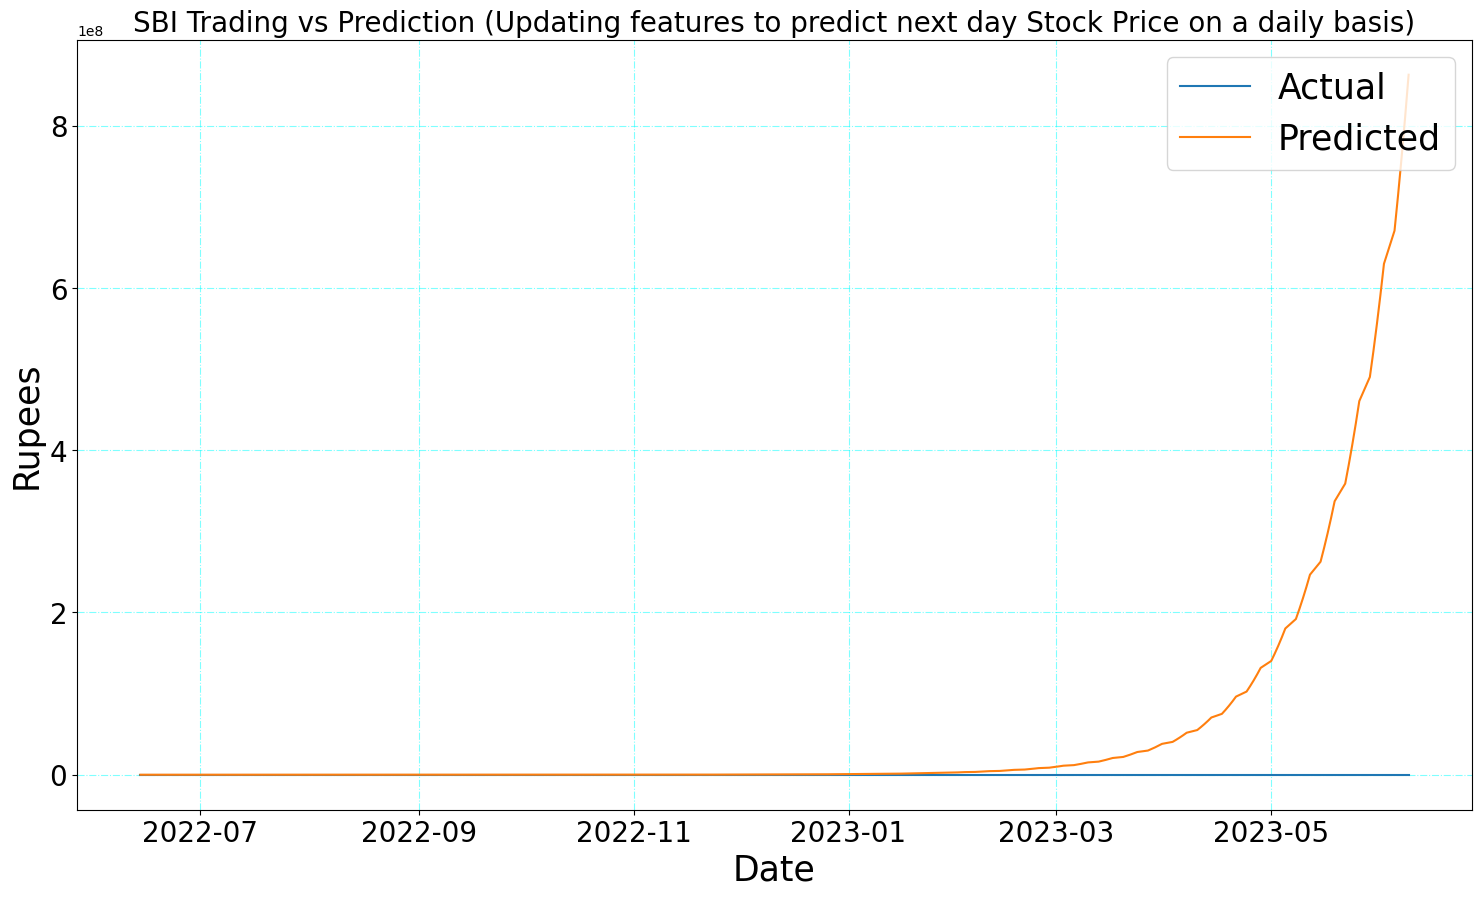

In [71]:
df_test_subset = df_test_subset.drop(df_test_subset.index[0])
fig, ax = plt.subplots(figsize = (18,10))
ax.plot(df_test_subset.index, df_test_subset['Actual'], label="Actual")
ax.plot(df_test_subset.index, df_test_subset['Predicted'], label="Predicted")

ax.set_title(f"{Stock} Trading vs Prediction (Updating features to predict next day Stock Price on a daily basis)", fontsize=20, color="black")
ax.set_xlabel("Date", fontsize=25, color="black")
ax.set_ylabel("Rupees", fontsize=25, color="black")
ax.tick_params(axis='both', labelsize=20)

ax.set_frame_on(True)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.grid(b=True, color="aqua", alpha=0.5, linestyle='-.')
plt.legend(loc='upper right', prop={'size': 25})
# plt.style.use('classic')
plt.show()


---

### <strong> <a style="color:black"> 6. Multi-Step Forecasting </a> </strong> 

**Second Chart:** It uses the predicted stock price as an input features to compute technical indicators and then those are used to predict next day stock price and, thus, all future prediction are made at time t=0 

---

In [16]:
df_test_multi_step = dt_model[dt_model.index > param['validation_end']]
df_test_multi_step['Predicted Adj Close'] = df_test_multi_step['Adj Close'] # will update it while looping
end_date = dt.datetime.today()
period_start_date = end_date - dt.timedelta(days=30) # 1 month prediction

In [17]:
rol_freq = param['past_day_returns_for_predicting']
predicted_dates = pd.bdate_range(start=period_start_date,end=end_date)

In [18]:
for date in predicted_dates[:-1]:
    price_trend_before_date = pd.DataFrame(df_test_multi_step.loc[df_test_multi_step.index < date, 'Predicted Adj Close'])
    df = price_trend_before_date.copy()
    features_ls = get_features_for_multi_step_forecasting(df, rol_freq, technical_indicator_features)
    features_ls = features_ls.reshape(-1,1)
    new_scaled_ls = scaler.transform(features_ls.T)
    new_scaled_ls = np.asarray(new_scaled_ls).astype(np.float32)
    new_scaled_ls = new_scaled_ls.reshape((new_scaled_ls.shape[0], new_scaled_ls.shape[1], 1))
    predicted_value = lstm_model.predict(new_scaled_ls)[0][0]
    next_working_date = (date + BDay(1)).replace(hour=0, minute=0, second=0, microsecond=0)
    date = date.replace(hour=0, minute=0, second=0, microsecond=0)
    df_test_multi_step.loc[next_working_date, 'Predicted Adj Close'] = predicted_value

1/1 [==============================] - 0s 14ms/step


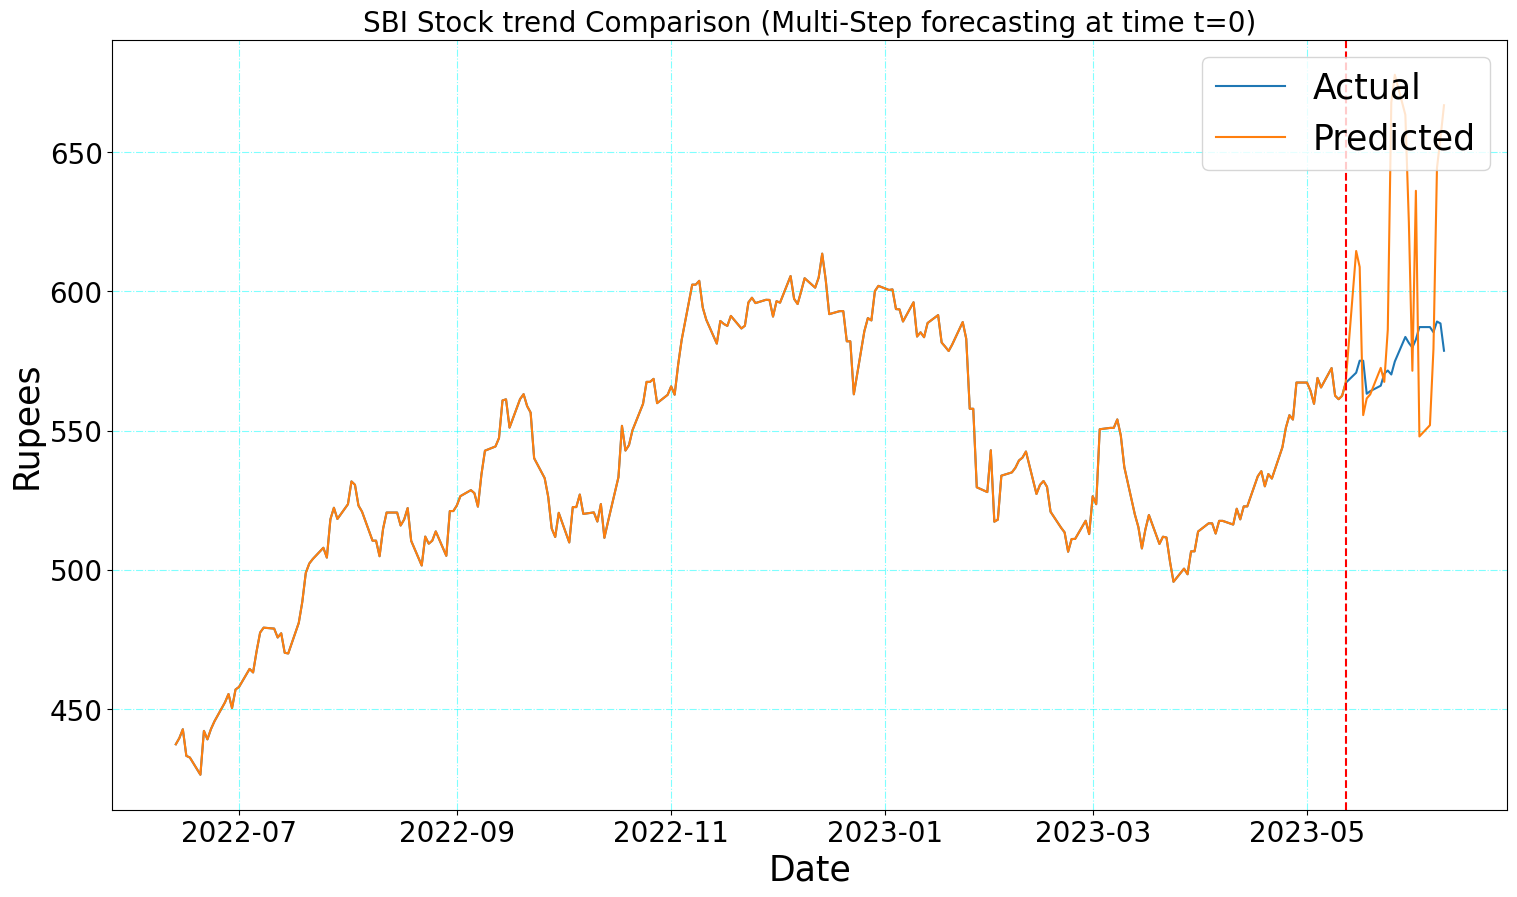

In [19]:
fig, ax = plt.subplots(figsize = (18,10))
ax.plot(df_test_multi_step.index, df_test_multi_step['Adj Close'], label="Actual")
ax.plot(df_test_multi_step.index, df_test_multi_step['Predicted Adj Close'], label="Predicted")

ax.set_title(f"{Stock} Stock trend Comparison (Multi-Step forecasting at time t=0)", fontsize=20, color="black")
ax.set_xlabel("Date", fontsize=25, color="black")
ax.set_ylabel("Rupees", fontsize=25, color="black")
ax.tick_params(axis='both', labelsize=20)

ax.set_frame_on(True)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.grid(b=True, color="aqua", alpha=0.5, linestyle='-.')
plt.legend(loc='upper right', prop={'size': 25})
plt.axvline(x=predicted_dates[0], color="r", linestyle="--")
plt.show()

In [ ]:
df_test_multi_step.to_clipboard()

In [ ]:
date = predicted_dates[-3]

In [72]:
df_test_subset.to_clipboard()

In [ ]:
price_trend_before_date = pd.DataFrame(df_test_multi_step.loc[df_test_multi_step.index < date, 'Predicted Adj Close'])
df = price_trend_before_date.copy()
features_ls = get_features_for_multi_step_forecasting(df, rol_freq, technical_indicator_features)
features_ls = features_ls.reshape(-1,1)
new_scaled_ls = scaler.transform(features_ls.T)
new_scaled_ls = np.asarray(new_scaled_ls).astype(np.float32)
new_scaled_ls = new_scaled_ls.reshape((new_scaled_ls.shape[0], new_scaled_ls.shape[1], 1))
predicted_value = lstm_model.predict(new_scaled_ls)[0][0]
next_working_date = (date + BDay(1)).replace(hour=0, minute=0, second=0, microsecond=0)
date = date.replace(hour=0, minute=0, second=0, microsecond=0)
df_test_multi_step.loc[next_working_date, 'Predicted Adj Close'] = predicted_value

In [ ]:
features_ls